In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


import pandas as pd
import numpy as np

### Import Patient, Admission and ICU Data. Impute '0' if Discharge Date or ICU Out time is not available in the data. In that case we'll assume the mortality information during hospital stay is not known

In [ ]:
df_icu = pd.read_csv('../ICUSTAYS.csv')
df_pat = pd.read_csv('../PATIENTS.csv')
df_adm = pd.read_csv('../ADMISSIONS.csv')
df_diag = pd.read_csv('../DIAGNOSES_ICD.csv')
df_adm['DISCHTIME'].fillna('0',inplace=True)
df_icu.OUTTIME.fillna('0',inplace=True)

Check sample of each data frame

##### Logic to find dead people during hospital stay is to check if the Date of Death is before the Discharge date or ICU out time. We'll add all Patient , visit and diagnosis list for all patients

In [ ]:
#Mortality Calculation

#Date of Death is before ICU Stay or Hospital Discharge for all Patients to find mortality count
all_pat = []
all_visits = []
all_diags = []
mortality = []
dead = False
# df_mort = df_pat[~df_pat.DOD.isnull()]
for i, row in df_pat.iterrows():
    
    pid = row['SUBJECT_ID']
#     print(pid)
    if ~df_pat[df_pat.SUBJECT_ID == pid].DOD.isnull().values[0]:
        ot = max(df_icu[df_icu.SUBJECT_ID ==pid].OUTTIME.values, default='0')
#         ot = pd.to_datetime(ot).reset_index(drop=True)
        dis_time = max(df_adm[df_adm.SUBJECT_ID == pid].DISCHTIME.values, default='0')
        dod = df_pat[df_pat.SUBJECT_ID == pid].DOD.values[0]
#         print(ot, dis_time, dod)
        dead = (dod <= ot) or (dod <= dis_time)
    if dead:
        mortality.append(1)
    else: 
        mortality.append(0)
    all_pat.append(pid)
    vids = list(df_adm[df_adm.SUBJECT_ID == pid]['HADM_ID'])
    all_visits.append(vids)
    pat_diags = []
    for v in vids:
        diags = list(df_diag[(df_diag.SUBJECT_ID == pid) & (df_diag.HADM_ID == v)]['ICD9_CODE'])
        pat_diags.append(diags)
    all_diags.append(pat_diags)
    dead = False

#### check if mortality rate matches with original paper and other data sanctity. We got 12.65% which is close to 13% as mentioned in the paper.

In [ ]:
x = np.array(mortality)
ind = np.where(x == 1)[0]
dead_pat_in_hosp = [all_pat[i] for i in ind]
len(dead_pat_in_hosp)

df_mort = df_pat[~df_pat.DOD.isnull()]
len(df_mort)
mort_pat = list(df_mort.SUBJECT_ID.values)
unmatched_pat = [d for d in mort_pat if d not in dead_pat_in_hosp]
print(f"Patient died after hospital admission is {len(unmatched_pat)} \
        and cohort mortality is {(len(dead_pat_in_hosp)/len(all_pat))*100}")


#### create dictionary for ICD9 codes so that we can handle only integers

In [ ]:
#Get dictionary index for all ICD9 codes
icd_uniq = df_diag.ICD9_CODE.unique()
# icd_uniq = ['A', 'B', 'A']
icd_dic = {}
i = 0
for code in icd_uniq:
    icd_dic[code] = i
    i += 1
len(icd_dic)

In [ ]:
print("Patient ID:", all_pat[3])
print("Dead:", mortality[3])
print("# of visits:", len(all_visits[3]))
for visit in range(len(all_visits[3])):
    print(f"\t{visit}-th visit id:", all_visits[3][visit])
    print(f"\t{visit}-th visit diagnosis labels:", all_diags[3][visit])
#     print(f"\t{visit}-th visit diagnosis codes:", [rtypes[label] for label in seqs[3][visit]])

#### Create custom Dataset to get sequences and target values (mortality)

In [ ]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, seqs, mortality):
        
        """
        TODO: Store `seqs`. to `self.x` and `hfs` to `self.y`.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        Do NOT permute the data.
        """
        
        # your code here
        self.x = seqs
        self.y = mortality
#         raise NotImplementedError
    
    def __len__(self):
        
        """
        TODO: Return the number of samples (i.e. patients).
        """
        
        # your code here
        return len(self.y)
#         raise NotImplementedError
    
    def __getitem__(self, index):
        
        """
        TODO: Generates one sample of data.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        """
        
        # your code here
        seq = self.x[index]
        hf = self.y[index]

        return seq, hf
#         raise NotImplementedError
        

dataset = CustomDataset(all_diags, mortality)

#### get Max number of visit and sequences from diagnostic code

In [ ]:
num_visits = [len(patient) for patient in all_visits]
num_codes = [len(visit) for patient in all_diags for visit in patient]
max_num_visits = max(num_visits)
max_num_codes = max(num_codes)
max_num_visits, max_num_codes

### write a collate function to group seq and y together for dataload

In [ ]:
def collate_fn(data):
    
    sequences, labels = zip(*data)
    y = torch.tensor(labels, dtype=torch.int64)
    num_patients = len(sequences)
    num_visits = [len(patient) for patient in sequences]
    num_codes = [len(visit) for patient in sequences for visit in patient]
    max_num_visits = 42 #max(num_visits)
    max_num_codes = 39 #max(num_codes)
#     print(max_num_visits, max_num_codes, len(y) )
    x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.float)
    for i_patient, patient in enumerate(sequences):
        for j_visit, visit in enumerate(patient):
            for k_diag, diag in enumerate(visit):
                if diag != diag:
#                     print(diag, i_patient, j_visit,k_diag) 
                    continue
                else: x[i_patient, j_visit,k_diag ] =icd_dic[diag]
#     x = x.type(torch.LongTensor)
#     y = y.type(torch.LongTensor)
    return x, y


#### Create Train , Validation and Test dataset

In [ ]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.7)

lengths = [split, len(dataset) - split]
train_dataset, val_test_dataset = random_split(dataset, lengths)


split = int(len(val_test_dataset)*0.7)
lengths = [split, len(val_test_dataset) - split]
val_dataset, test_dataset = random_split(val_test_dataset, lengths)


print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))
print("Length of test dataset:", len(test_dataset))

#### Load the inital data into train_loader, val_loader, test_loader

In [ ]:
def load_data(train_dataset, val_dataset, test_dataset, batch_size, collate_fn):
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

batch_size = 128
train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size, collate_fn)

in_feature = 39
seq_len = 42
n_heads = 32
factor = 5 # M - dense interpolation factor
num_class = 2
num_layers = 1 #N


### Import Sand and relevant classes to run our Training and evaluate job

In [ ]:
from sand_144 import SAnD

In [ ]:
clf = sand_144.MyNeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 1e-5, "betas": (0.9, 0.98), "eps": 4e-09, "weight_decay": 5e-4},
)


In [ ]:
# training network
clf.fit(
    {"train": train_loader,
     "val": val_loader},
     epochs= 1
)

In [ ]:
import tqdm

def my_evaluate(model):

    correct = 0.0
    total = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pbar = tqdm.tqdm(total=len(test_loader.dataset))
#     model = SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    Y_pred= []
    Y_true = []
    for x, y in test_loader:
    #     print("Here is type & shape", type(y), y.shape)
        b_size = y.shape[0]
        total += y.shape[0]
        x = x.to(device) if isinstance(x, torch.Tensor) else [i.to(device) for i in x]
        y = y.to(device)

        pbar.set_description("\033[32m"+"Evaluating"+"\033[0m")
        pbar.update(b_size)

        outputs = model(x)
    #     print(outputs)
        idx = torch.argmax(outputs, dim=1) 
        print(idx)
    #     _, predicted = torch.max(outputs, 1)
        Y_pred.append(idx)
        Y_true.append(y)

    #     multilabel_auroc(predicted, y,num_labels=2, average="macro", thresholds=None)

    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_true = np.concatenate(Y_true, axis=0)
    
    return Y_pred, Y_true


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    Y_pred,
    Y_true,
    multi_class="raise",
    average="micro",
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, auc, precision_recall_curve
p = precision_score(Y_true, Y_pred)
r = recall_score(Y_true, Y_pred)
p, r, thresholds1  = precision_recall_curve(Y_true, Y_pred)
auc_score = auc(r, p)
print(auc_score)

## Run the model and evaluate for different perparameter combination

In [ ]:

param = [[6,1], [12,1], [18,1], [6,4],[12,4], [18,4]]
ROC = []

for factor, num_layers in param:
    print(factor, num_layers)
    clf = sand_144.MyNeuralNetworkClassifier(
        SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
        nn.CrossEntropyLoss(),
        optim.Adam, optimizer_config={"lr": 1e-5, "betas": (0.9, 0.98), "eps": 4e-09, "weight_decay": 5e-4},
        )
    clf.fit(
            {"train": train_loader,
             "val": val_loader},
             epochs= 1
            )
    
    Y_pred, Y_true = my_evaluate(clf.model)
    roc = roc_auc_score(
            Y_pred,
            Y_true,
            multi_class="raise",
            average="micro",
            )
    ROC.append(roc)


In [ ]:
ROC

In [ ]:
import matplotlib.pyplot as plt

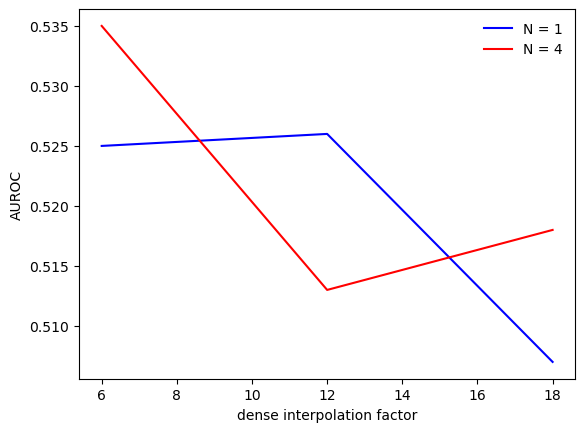

In [51]:
x = [6, 12, 18]
y1 = [.525, .526, .507]
y2 = [.535, 0.513, 0.518]

# Plot the data and set the line colors and labels
plt.plot(x, y1, color='blue', label='N = 1')
plt.plot(x, y2, color='red', label='N = 4')

# Add a legend with the line colors
plt.legend(frameon=False)
plt.xlabel("dense interpolation factor") 
plt.ylabel("AUROC")

# Show the plot
plt.show()